In [96]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [97]:
# Fetch stock data
ticker = "TSLA"
period = "2y"

stock = yf.Ticker(ticker)
data = stock.history(period=period)

In [98]:
# Fetch S&P 500 historical data
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period=period)

data_sp500 = sp500_data[['Close']] 
data_sp500.columns = ['SP500_Close']    # Rename the columns for clarity and to avoid conflicts upon merging

# Merge the S&P 500 data with your existing DataFrame based on the date index
data = data.merge(data_sp500, how='left', left_index=True, right_index=True)

In [99]:
# Drop 'Dividends' and 'Stock Splits' and compute additional technical indicators
data = data.drop(columns=['Dividends', 'Stock Splits'])

# data['52w_high'] = data['Close'].rolling(window=252, min_periods=1).max()
# data['52w_low'] = data['Close'].rolling(window=252, min_periods=1).min()

short_span, long_span = 10, 50

data['EMA_Short'] = data['Close'].ewm(span=short_span, adjust=False).mean()
data['EMA_Long'] = data['Close'].ewm(span=long_span, adjust=False).mean()

data['SMA_Short'] = data['Close'].rolling(window=short_span).mean()
data['SMA_Long'] = data['Close'].rolling(window=long_span).mean()

# RSI
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2

In [100]:
data.head()

,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,SMA_Short,SMA_Long,RSI,MACD
Date,,,,,,,,,,,,
2022-02-22 00:00:00-05:00,278.043335,285.576660,267.033325,273.843323,83288100,4304.759766,273.843323,273.843323,NaN,NaN,NaN,0.000000
2022-02-23 00:00:00-05:00,276.809998,278.433319,253.520004,254.679993,95256900,4225.500000,270.359081,273.091820,NaN,NaN,NaN,-1.528699
2022-02-24 00:00:00-05:00,233.463333,267.493347,233.333328,266.923340,135322200,4288.700195,269.734401,272.849918,NaN,NaN,NaN,-1.732299
2022-02-25 00:00:00-05:00,269.743347,273.166656,260.799988,269.956665,76067700,4384.649902,269.774812,272.736458,NaN,NaN,NaN,-1.630099
2022-02-28 00:00:00-05:00,271.670013,292.286682,271.570007,290.143341,99006900,4373.939941,273.478181,273.419080,NaN,NaN,NaN,0.078883


In [101]:
data.describe()

,Open,High,Low,Close,Volume,SP500_Close,EMA_Short,EMA_Long,SMA_Short,SMA_Long,RSI,MACD
count,502.000000,502.000000,502.000000,502.000000,5.020000e+02,502.000000,502.000000,502.000000,493.000000,453.000000,489.000000,502.000000
mean,232.567955,237.729515,227.029874,232.394748,1.137830e+08,4215.380784,233.116741,235.497046,232.369830,230.130110,48.829858,-0.970742
std,51.212356,52.045839,50.142874,50.965478,4.039960e+07,318.008126,48.942618,41.137398,49.893991,41.613862,20.042448,10.631334
min,103.000000,111.750000,101.809998,108.099998,4.186470e+07,3577.030029,119.608192,153.127073,115.056998,150.403800,6.919326,-25.038445
25%,193.187504,197.542500,189.440002,193.827499,8.613502e+07,3970.067505,193.253798,201.853246,192.459000,191.599200,33.628548,-9.099143
50%,235.128334,240.245003,231.329994,236.083336,1.072428e+08,4158.505127,236.801337,242.639002,235.439001,237.627400,48.748164,-0.525311
75%,265.906662,269.905006,260.160004,264.989998,1.353815e+08,4446.762329,264.684661,264.161238,262.682001,256.634999,62.523342,5.221624
max,378.766663,384.290009,362.433319,381.816681,3.065906e+08,5029.729980,353.545644,317.726237,360.427002,314.416801,97.529933,24.909357


In [102]:
# Normalize features
features = data.columns.tolist()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[features].bfill())

In [103]:
# Create sequences
def create_sequences(data, sequence_length=30):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length=sequence_length)

In [104]:
# Define LSTM model with L2 Regularization and Dropout
def build_model(input_shape, num_layers=1, size_layer=128, dropout_rate=0.8, l2_rate=0.01, learning_rate=0.01):
    model = Sequential()

    for i in range(num_layers):
        model.add(Bidirectional(LSTM(size_layer, return_sequences=(
            i < num_layers - 1), input_shape=input_shape, kernel_regularizer=l2(l2_rate))))

        model.add(Dropout(dropout_rate))

    model.add(Dense(1, kernel_regularizer=l2(l2_rate)))

    model.compile(optimizer=tf.keras.optimizers.Adam(
        learning_rate=learning_rate), loss='mean_squared_error')

    return model

In [114]:
num_layers = 1
size_layer = 100
epoch = 10
dropout_rate = 0.2
learning_rate = 0.001
l2_rate=0.0001
batch_size = 32

In [115]:
# Time Series Cross-validation with Early Stopping
tscv = TimeSeriesSplit(n_splits=10)
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)

# Define a separate test set for final evaluation
test_size = sequence_length # int(len(X) * 0.1)  # use the last 10% of the data for testing
X_train_final, X_test_final = X[:-test_size], X[-test_size:]
y_train_final, y_test_final = y[:-test_size], y[-test_size:]

best_val_loss = np.inf
best_model = None
best_history = None

for train_index, val_index in tscv.split(X_train_final):
    X_train, X_val = X_train_final[train_index], X_train_final[val_index]
    y_train, y_val = y_train_final[train_index], y_train_final[val_index]
    model = build_model(input_shape=(X_train_final.shape[1], X_train_final.shape[2]),
                        num_layers=num_layers,
                        size_layer=size_layer,
                        dropout_rate=dropout_rate,
                        l2_rate=l2_rate,
                        learning_rate=learning_rate
                        )

    # Fit the model with Early Stopping
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epoch, validation_data=(
        X_val, y_val), callbacks=[early_stopping], verbose=1)

    val_loss = np.min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_history = history

Epoch 1/10
2/2 [==============================] - 11s 2s/step - loss: 0.2649 - val_loss: 0.0407
Epoch 2/10
2/2 [==============================] - 0s 43ms/step - loss: 0.0989 - val_loss: 0.0429
Epoch 3/10
2/2 [==============================] - 0s 43ms/step - loss: 0.0877 - val_loss: 0.0181
Epoch 4/10
2/2 [==============================] - 0s 52ms/step - loss: 0.0315 - val_loss: 0.0403
Epoch 5/10
2/2 [==============================] - 0s 56ms/step - loss: 0.0690 - val_loss: 0.0398
Epoch 6/10
2/2 [==============================] - 0s 60ms/step - loss: 0.0449 - val_loss: 0.0213
Epoch 7/10
2/2 [==============================] - 0s 74ms/step - loss: 0.0274 - val_loss: 0.0122
Epoch 8/10
2/2 [==============================] - 0s 64ms/step - loss: 0.0214 - val_loss: 0.0144
Epoch 9/10
2/2 [==============================] - 0s 58ms/step - loss: 0.0307 - val_loss: 0.0135
Epoch 10/10
2/2 [==============================] - 0s 57ms/step - loss: 0.0367 - val_loss: 0.0102
Epoch 1/10
3/3 [==============

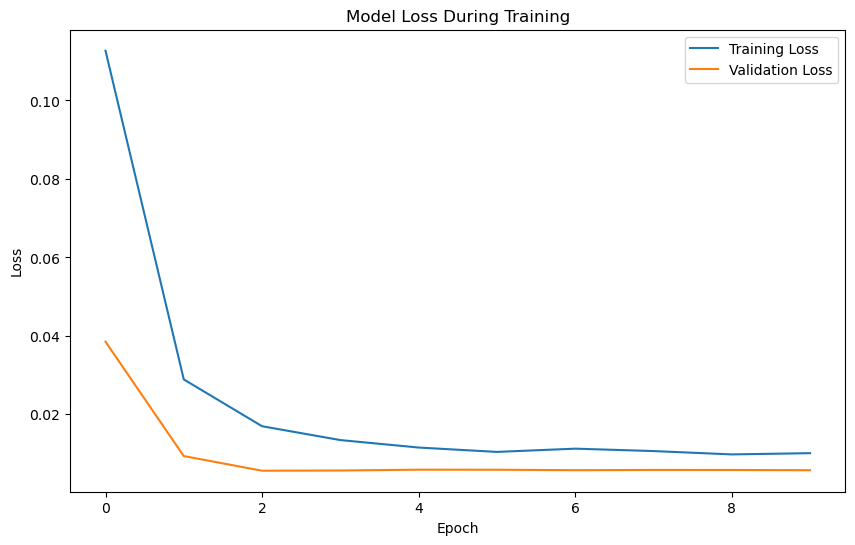

In [116]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [117]:
# Re-train the best model on the combined training + validation set and evaluate on the separate test set
best_model.fit(X_train_final, y_train_final, batch_size=batch_size, epochs=epoch, verbose=1)

Epoch 1/10
14/14 [==============================] - 0s 21ms/step - loss: 0.0098
Epoch 2/10
14/14 [==============================] - 0s 28ms/step - loss: 0.0097
Epoch 3/10
 8/14 [================>.............] - ETA: 0s - loss: 0.0090

14/14 [==============================] - 0s 24ms/step - loss: 0.0089
Epoch 4/10
14/14 [==============================] - 0s 31ms/step - loss: 0.0089
Epoch 5/10
14/14 [==============================] - 0s 24ms/step - loss: 0.0086
Epoch 6/10
14/14 [==============================] - 0s 33ms/step - loss: 0.0088
Epoch 7/10
14/14 [==============================] - 0s 32ms/step - loss: 0.0079
Epoch 8/10
14/14 [==============================] - 0s 29ms/step - loss: 0.0078
Epoch 9/10
14/14 [==============================] - 0s 23ms/step - loss: 0.0073
Epoch 10/10
14/14 [==============================] - 0s 22ms/step - loss: 0.0073


1/1 [==============================] - 2s 2s/step


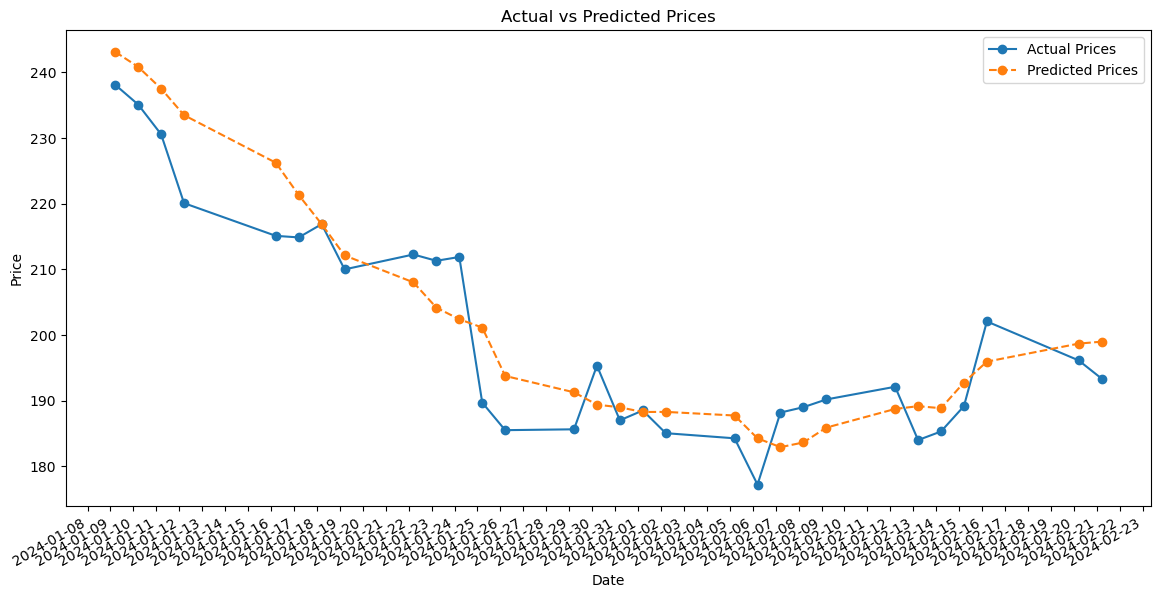

Mean Squared Error (MSE): 39.059498775866814
Mean Absolute Error (MAE): 5.462135314941406
Root Mean Squared Error (RMSE): 6.249759897457406
R-squared (R2): 0.8568163263832573
Mean Absolute Percentage Error (MAPE): 0.027192349473707373


In [118]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.dates as mdates 

# Plot predictions
def plot_predictions(model, X, y, dates, scaler, title='Actual vs Predicted Prices'):
    predictions = model.predict(X)
    
    predictions = scaler.inverse_transform(
        np.pad(predictions, [(0, 0), (0, len(features) - 1)], 'constant'))[:, 0]
    actual = scaler.inverse_transform(
        np.pad(y.reshape(-1, 1), [(0, 0), (0, len(features) - 1)], 'constant'))[:, 0]
    
    plt.figure(figsize=(14, 7))
    plt.plot(dates, actual, label='Actual Prices', marker='o')
    plt.plot(dates, predictions, label='Predicted Prices', linestyle='--', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    # Format the x-axis to display dates clearly
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gcf().autofmt_xdate()  # Rotation
    
    plt.show()

    # Calculate evaluation metrics
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predictions)
    mape = mean_absolute_percentage_error(actual, predictions)

    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    print("Mean Absolute Percentage Error (MAPE):", mape)


test_dates = data.index[-len(X_test_final):]
plot_predictions(best_model, X_test_final, y_test_final, test_dates, scaler)

### Mean Squared Error (MSE) and Mean Absolute Error (MAE):
- These metrics measure the average error between the predicted and actual values.
- Lower values indicate better performance.
- However, the absolute scale of these metrics is dependent on the scale of your target variable. Therefore, it's difficult to define a universally "good" threshold. It's more informative to compare these metrics across different models or variations of your LSTM model.

### Root Mean Squared Error (RMSE):
- RMSE is in the same units as the target variable, which can make it more interpretable.
- Similar to MSE and MAE, lower values are desirable.
- Like MSE and MAE, it's more useful for comparing models rather than establishing absolute thresholds.

### R-squared (R2):
- R2 measures the proportion of the variance in the dependent variable that is predictable from the independent variables.
- R2 ranges from 0 to 1, with higher values indicating better fit.
- A value of 1 indicates that the model explains all the variability of the response data around its mean. However, a high R2 value doesn't necessarily mean a good model, as it may overfit.
- Generally, R2 values closer to 1 are desirable, but the interpretation depends on the context and the complexity of the model.

### Mean Absolute Percentage Error (MAPE):
- MAPE measures the average absolute percentage difference between predicted and actual values.
- Lower values indicate better performance.
- A MAPE of 0% indicates a perfect fit, but in practice, it's rare to achieve such a value.
- It's common to interpret MAPE in the context of the variability of the target variable. For example, a MAPE below 10% might be considered good in some domains.

In [119]:
import datetime


def weekdays_left_in_week():
    # Get the current date
    today = datetime.date.today()

    # If today is Saturday or Sunday, return 0 since there are no weekdays left
    if today.weekday() >= 5:
        return 1

    # Calculate the number of days left in the week
    days_left = 5 - today.weekday() - 1  # Subtract 1 to exclude the current day

    return days_left


# Example usage
print("Weekdays left in the week:", weekdays_left_in_week())

Weekdays left in the week: 1


In [120]:
# Predicting Future Prices for the Next 5 Days
future_days = weekdays_left_in_week()
# Starting point for future predictionsv
last_sequence = scaled_data[-sequence_length:]
future_predictions = []

for _ in range(future_days):
    # Reshape the last sequence for prediction
    last_sequence_reshaped = last_sequence.reshape(
        (1, sequence_length, scaled_data.shape[1]))

    next_price = best_model.predict(last_sequence_reshaped)[
        0, 0]   # Predict the next price
    future_predictions.append(next_price)

    # Update the last sequence with the predicted value
    new_row = np.zeros(scaled_data.shape[1])
    new_row[0] = next_price  # Update the sequence with the predicted price
    last_sequence = np.vstack([last_sequence[1:], new_row])  # Slide the window

future_prices = scaler.inverse_transform(np.pad(np.array(
    future_predictions).reshape(-1, 1), [(0, 0), (0, scaled_data.shape[1] - 1)], 'constant'))[:, 0]

1/1 [==============================] - 0s 21ms/step


In [121]:
future_prices

array([200.13788], dtype=float32)

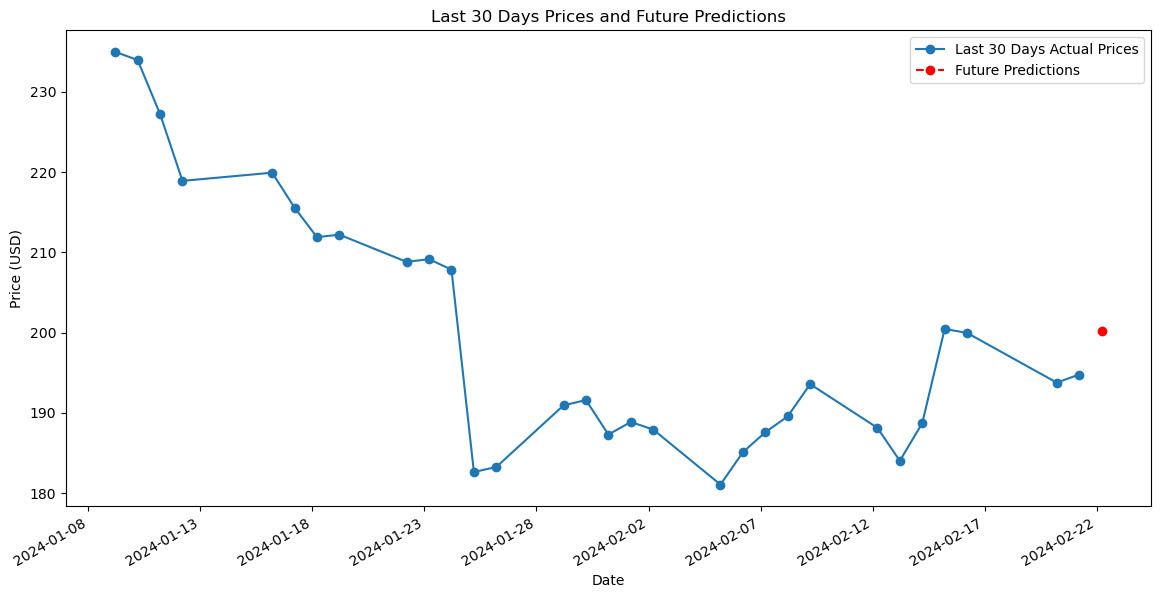

In [122]:
# Import necessary libraries
import matplotlib.dates as mdates

# Step 1: Select the last 30 days of actual price data
last_30_days = data['Close'][-30:]

# Step 2: Generate dates for the last 30 days and future predictions
last_30_dates = last_30_days.index
future_dates = pd.date_range(start=last_30_dates[-1] + pd.Timedelta(days=1), periods=future_days)

# Step 3: Plot the last 30 days of actual prices and the future predictions
plt.figure(figsize=(14, 7))

# Plot the last 30 days of actual prices
plt.plot(last_30_dates, last_30_days, label='Last 30 Days Actual Prices', marker='o', linestyle='-')

# Plot the future predictions
plt.plot(future_dates, future_prices, label='Future Predictions', marker='o', linestyle='--', color='red')

# Formatting the plot
plt.title('Last 30 Days Prices and Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)

# Improve date formatting and layout
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.gcf().autofmt_xdate()  # Rotation

plt.show()